In [4]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.6 MB/s eta 0:00:00


In [5]:
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from collections import Counter
import xgboost as xgb
from xgboost import plot_importance
from catboost import CatBoostRegressor
from textblob import TextBlob

import tensorflow as tf

import gensim.downloader
from gensim.models import Word2Vec
import nltk

In [7]:
data_path = "data/html/*.html"

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:

        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text
                    }
                )

        code2convos[file_code] = convo_texts

100%|██████████| 127/127 [00:23<00:00,  5.47it/s]


In [ ]:
pprint(code2convos["0031c86e-81f4-4eef-9e0e-28037abf9883"])

[{'role': 'user',
  'text': 'Load a CSV file into a Pandas in Python. The file is named '
          "'cs412_hw1_dataset.csv' and contains columns like 'Species', "
          "'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', "
          "'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and "
          "'Health Metrics'. \n"},
 {'role': 'assistant',
  'text': 'You can load a CSV file into a Pandas DataFrame in Python using the '
          "pandas.read_csv() function. Here's how you can do it for your "
          'specific CSV file:pythonCopy codeimport pandas as pd\n'
          '\n'
          '# Specify the file path\n'
          "file_path = 'cs412_hw1_dataset.csv'\n"
          '\n'
          '# Load the CSV file into a Pandas DataFrame\n'
          'df = pd.read_csv(file_path)\n'
          '\n'
          '# Display the first few rows of the DataFrame to verify the data '
          'has been loaded\n'
          'print(df.head())\n'
          "This code assume

#### Things to do:
- Prompt matching with questions
- Feature Engineering
- Question Grades preparation
- Train/Test split
- Fitting a model for predicting the scores

#### Prompt Matching
> We want to match the prompts with the questions in the Homework Let's
> do it with a simple term frequency vectorizing method. For each prompt,
> we will come with a vector that represents it. We will do the same
> thing with each of the homework questions. Then, we will calculate the
> vectors distanance to do the matching

In [8]:
prompts = []
characters_to_remove = ["\n","`",'\\']
code2prompts = defaultdict(list)
code2prompts_str = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
          for element in characters_to_remove: #Removal of such characters
            conv["text"] = conv["text"].replace(element,"")
          prompts.append(conv["text"])
          user_prompts.append(conv["text"])
    code2prompts[code] = user_prompts

In [9]:
questions = [ #Removed a question here wasn't leading to points also removed some characters!
#####################
    """Load training dataset
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset and Preprocessing
Understanding the Dataset:
Find the shape of the dataset (number of samples and number of attributes). (Hint: You can use the **shape** function)
Display variable names (both dependent and independent).
Display the summary of the dataset. (Hint: You can use the **info** function)
Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing:
Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**
Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""Set X and y, split data

Shuffle the dataset.
Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations

Correlations of features with health
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

Feature Selection
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

Hypothetical Driver Features
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

""",
#####################
"""Tune Hyperparameters
Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values.
Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)*
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen
Re-train model with the hyperparameters you have chosen in part 5).
Plot the tree you have trained.
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set
Predict the labels of testing data using the tree you have trained in step 6.
Report the classification accuracy.
Plot & investigate the confusion matrix. Fill the following blanks.
The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split"""
#####################
]
for item in questions:
  for element in characters_to_remove: #Removal of such characters
    item = item.replace(element,"")


In [10]:
#Train A Word2Vec Model
nltk.download('punkt')

# Tokenize sentences and create a flat list of sentences
sentence_load = []
test_list = list(code2prompts.values())
test_list.append(questions)
for sentences in test_list:
    for sentence in sentences:
        # Tokenize each sentence
        tokenized_sentence = nltk.word_tokenize(sentence)
        sentence_load.append(tokenized_sentence)

# Training the Word2Vec model
vector_size = 600
window = 5
min_count = 2

hw_grading_word2vec_model = Word2Vec(
    sentences=sentence_load,
    vector_size=vector_size,
    window=window,
    min_count= min_count,
    workers=10
)
hw_grading_word2vec_model
#Train A Word2Vec Model

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [11]:
def vectorize_sentence(prompt): ## Each sentence of prompt being vectorized
  user_vector_list = list([])
  for sentence in prompt:
    tokens = sentence.split()
    word_vectors = [hw_grading_word2vec_model.wv[word] for word in tokens if word in hw_grading_word2vec_model.wv]
    if not word_vectors:
      user_vector_list.append(np.zeros(hw_grading_word2vec_model.vector_size))
      continue
    user_vector_list.append(np.mean(word_vectors, axis=0))
  return user_vector_list

code2prompts_word2vec = dict()
for code, user_prompts in code2prompts.items():
  if len(user_prompts) == 0:
      print(code+".html")
      continue
  prompts_word2Vec = pd.DataFrame(vectorize_sentence(user_prompts))
  code2prompts_word2vec[code] = prompts_word2Vec

questions_word2Vec = pd.DataFrame(vectorize_sentence(questions)) #Questions vectorized


139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html


In [12]:
code2prompts_word2vec["7ac3f7a5-bdbb-470c-a1b3-03da5887a408"]

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,0.281078,-0.088557,-0.098255,-0.157248,0.233831,0.055042,0.043039,0.267248,0.039721,0.035685,...,-0.278731,-0.058992,-0.110098,-0.129683,0.047381,-0.024558,0.082022,-0.186714,0.029714,-0.124721
1,0.627861,-0.098042,-0.183616,-0.219659,0.461294,-0.099056,0.040728,0.328694,0.139460,-0.098010,...,-0.179239,-0.128017,-0.154500,-0.271102,0.257323,0.213268,0.107339,-0.256820,0.082110,-0.005561
2,0.202236,0.088858,0.152539,-0.295626,0.272306,0.000687,0.081106,0.427696,-0.203166,0.353610,...,-0.498659,0.036326,-0.024553,0.052542,0.096338,0.159495,-0.114000,-0.308382,-0.002704,-0.004816
3,0.068614,-0.025498,0.190797,0.109167,0.065806,-0.047239,0.278183,0.503926,-0.051280,0.146764,...,-0.175439,-0.034973,0.049885,-0.157936,0.202591,0.254367,-0.270753,-0.398953,-0.086168,-0.366486
4,0.556824,-0.066693,-0.259035,-0.157352,0.408325,0.007264,0.035359,0.323959,0.106916,-0.055485,...,-0.167431,-0.102325,-0.164331,-0.202905,0.281176,0.234709,0.099771,-0.327838,0.000999,-0.080393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.539565,-0.024684,-0.308080,-0.287091,0.423395,0.178955,0.013329,0.475479,0.012253,-0.211225,...,-0.085866,0.041815,-0.138445,-0.154354,-0.064673,0.158307,0.293216,-0.185918,0.038994,-0.013668
60,0.611260,-0.129546,-0.036025,0.010670,0.056543,-0.062587,0.296871,0.447619,-0.129771,-0.131969,...,-0.070463,0.313765,0.046357,-0.130170,0.319541,0.254822,-0.182899,0.107410,0.138277,-0.039892
61,0.491423,-0.139092,0.047203,-0.223959,0.307075,-0.137413,0.340068,0.529669,-0.114495,-0.086778,...,-0.287546,0.087754,-0.100654,-0.250421,0.335643,0.340247,-0.160215,-0.162428,0.031856,-0.045962
62,0.469981,-0.172135,-0.042530,-0.284690,0.279648,0.073386,-0.059460,0.436186,0.026192,-0.045478,...,-0.320072,-0.030986,0.011347,-0.084802,0.168515,0.096397,0.070296,-0.165302,0.008884,-0.049961


In [ ]:
questions_word2Vec

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,0.334054,-0.165549,-0.187190,0.001015,0.284175,0.103799,-0.033110,0.499756,0.108182,0.045691,...,-0.158972,-0.063274,-0.061899,0.002246,0.118406,0.075493,0.229048,-0.218371,-0.165487,-0.167906
1,0.355613,-0.054147,-0.248714,0.036604,0.303894,0.062355,0.098537,0.506453,0.117178,-0.003320,...,-0.192208,-0.096361,-0.132159,-0.052209,0.166488,0.205694,0.131258,-0.235862,-0.001350,-0.239837
2,0.233433,-0.017932,-0.025229,0.006700,0.234682,0.009778,0.055527,0.570148,-0.064181,0.193297,...,-0.245627,0.084463,0.037327,0.162778,0.013630,-0.014076,0.109680,-0.117132,-0.115835,-0.042163
3,0.118933,0.001032,0.008601,-0.079649,0.144947,0.075897,0.177549,0.502592,-0.105258,0.100770,...,-0.348617,0.037002,-0.137363,-0.087381,0.092801,-0.141394,-0.034200,-0.193288,0.175783,-0.261978
4,0.347224,-0.019783,-0.281861,0.080598,0.197848,0.074818,0.209337,0.453113,-0.051229,-0.225439,...,-0.035994,-0.085129,-0.109082,-0.084708,0.221362,0.176485,0.035533,-0.215965,0.152957,-0.194774
5,0.301151,-0.020135,-0.440134,-0.007990,0.244893,0.179629,0.209913,0.558074,0.030136,-0.206269,...,-0.069494,0.007750,-0.216312,-0.024964,0.148411,0.153528,0.216822,-0.209834,-0.020507,-0.300818
6,0.367271,-0.080764,-0.231985,0.017310,0.219944,0.021211,0.142974,0.570212,0.021656,-0.085534,...,-0.054887,0.052614,-0.038281,-0.040000,0.203576,0.130554,0.161093,-0.099457,-0.088368,-0.193719
7,0.491539,-0.353741,-0.157005,-0.231383,0.266173,-0.033647,-0.098728,0.946236,0.095647,0.003197,...,-0.331921,-0.075644,0.072585,-0.022293,0.425239,-0.010053,0.136234,-0.091773,-0.074773,-0.247461


In [13]:
code2cosine_word2vec = dict()
for code, user_prompts_word2vec in code2prompts_word2vec.items():
    code2cosine_word2vec[code] = pd.DataFrame(cosine_similarity(questions_word2Vec,user_prompts_word2vec))

In [14]:
code2questionmapping_word2vec = dict()
for code, cosine_scores in code2cosine_word2vec.items():
    code2questionmapping_word2vec[code] = code2cosine_word2vec[code].max(axis=1).tolist()


question_mapping_scores_word2vec = pd.DataFrame(code2questionmapping_word2vec).T
question_mapping_scores_word2vec.reset_index(inplace=True)
question_mapping_scores_word2vec.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores_word2vec.rename(columns={"index" : "code"}, inplace=True)

question_mapping_scores_word2vec #Similarity matrix between questions and prompts of user

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.952711,0.951270,0.884929,0.959028,0.932576,0.911666,0.929767,0.854167
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.958293,0.953984,0.986580,0.953424,0.999657,0.968997,0.928632,0.983194
2,041f950b-c013-409a-a642-cffff60b9d4b,0.941022,0.967280,0.781389,0.945344,0.891189,0.914617,0.964667,0.800422
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.868801,0.893608,0.849547,0.897393,0.931599,0.885493,0.930022,0.962929
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.936894,0.946995,0.956964,0.952703,0.986760,0.967873,0.990835,0.975922
...,...,...,...,...,...,...,...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.932791,0.943424,0.833557,0.900932,0.925362,0.999155,0.998493,0.988883
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.913651,0.949195,0.996389,0.991605,0.990601,0.934615,0.993281,0.973254
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.983405,0.999416,0.996439,0.999493,0.999434,0.998351,0.999116,0.980384
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,0.979533,0.993886,0.951647,0.999674,0.986511,1.000000,1.000000,0.940119


# Feature Engineering
- Number of prompts that a uers asked
- Number of complaints that a user makes e.g "the code gives this error!"
- User prompts average number of characters

In [15]:
code2features = defaultdict(lambda : defaultdict(int))

keywords2search = ["error", "no", "thank", "next", "Entropy","how"]
keywords2search = [k.lower() for k in keywords2search]

for code, convs in code2convos.items():
  if len(convs) == 0:
      print(code)
      continue
  for c in convs:
    text = c["text"].lower()
    if c["role"] == "user":
        # User Prompts

        # count the user prompts
        code2features[code]["#user_prompts"] += 1

        # count the keywords
        for kw in keywords2search:
            code2features[code][f"#{kw}"] +=  len(re.findall(rf"\b{kw}\b", text))

        code2features[code]["prompt_avg_chars"] += len(text)

        text = re.sub(r'[^\w\s]', '', text)
        words = text.split()
        blob = TextBlob(text)
        code2features[code]["unique_avg_chars"] += len(words)
        code2features[code]["sentiment_point"] += blob.sentiment.polarity

    else:
        # ChatGPT Responses
        code2features[code]["response_avg_chars"] += len(text)
        code2features[code]["response_unique_avg_chars"] += len(words)

    code2features[code]["prompt_avg_chars"] /= code2features[code]["#user_prompts"]
    code2features[code]["response_avg_chars"] /= code2features[code]["#user_prompts"]
    code2features[code]["unique_avg_chars"] /= code2features[code]["#user_prompts"]
    code2features[code]["sentiment_point"] /= code2features[code]["#user_prompts"]
    code2features[code]["response_unique_avg_chars"] /= code2features[code]["#user_prompts"]

139235c7-736c-4237-92f0-92e8c116832c
668ad17e-0240-49f7-b5a7-d22e502554c6
b0640e51-6879-40cb-a4f5-329f952ef99d
da6b70d5-29f6-491a-ad46-037c77067128


In [16]:
df_word2vec = pd.DataFrame(code2features).T
df_word2vec.head(5)

,#user_prompts,#error,#no,#thank,#next,#entropy,#how,prompt_avg_chars,unique_avg_chars,sentiment_point,response_avg_chars,response_unique_avg_chars
0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,12.0,2.200646,0.322617,5.105060e-03,212.206370,4.515444
0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,4.0,0.304163,0.055770,3.643319e-07,113.633582,1.003644
041f950b-c013-409a-a642-cffff60b9d4b,9.0,2.0,0.0,1.0,0.0,3.0,2.0,0.249785,0.052109,2.469137e-03,17.187601,0.466228
04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,9.0,0.123346,0.017618,8.656510e-07,107.092566,0.352239
089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,20.0,0.017986,0.003110,2.254281e-05,18.850913,0.267488


In [17]:
# reading the scores
scores = pd.read_csv("data/scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# show examples
scores.head()

,code,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0


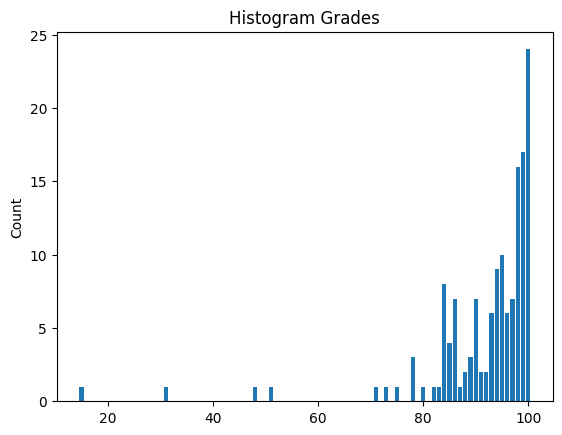

In [18]:
#Grades distribution

plt.title('Histogram Grades')
plt.hist(scores["grade"], rwidth=.8, bins=np.arange(min(scores["grade"]), max(scores["grade"])+2) - 0.5)
plt.ylabel('Count')
plt.show()

In [19]:
df_word2vec.reset_index(inplace=True, drop=False)
df_word2vec.rename(columns={"index": "code"}, inplace=True)

df_word2vec.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,#how,prompt_avg_chars,unique_avg_chars,sentiment_point,response_avg_chars,response_unique_avg_chars
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,12.0,2.200646,0.322617,5.105060e-03,212.206370,4.515444
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,4.0,0.304163,0.055770,3.643319e-07,113.633582,1.003644
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,2.0,0.0,1.0,0.0,3.0,2.0,0.249785,0.052109,2.469137e-03,17.187601,0.466228
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,9.0,0.123346,0.017618,8.656510e-07,107.092566,0.352239
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,20.0,0.017986,0.003110,2.254281e-05,18.850913,0.267488


In [20]:
df_word2vec = pd.merge(df_word2vec, question_mapping_scores_word2vec, on="code", how="left")
df_word2vec.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,#how,prompt_avg_chars,unique_avg_chars,...,response_avg_chars,response_unique_avg_chars,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,12.0,2.200646,0.322617,...,212.206370,4.515444,0.952711,0.951270,0.884929,0.959028,0.932576,0.911666,0.929767,0.854167
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,4.0,0.304163,0.055770,...,113.633582,1.003644,0.958293,0.953984,0.986580,0.953424,0.999657,0.968997,0.928632,0.983194
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,2.0,0.0,1.0,0.0,3.0,2.0,0.249785,0.052109,...,17.187601,0.466228,0.941022,0.967280,0.781389,0.945344,0.891189,0.914617,0.964667,0.800422
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,9.0,0.123346,0.017618,...,107.092566,0.352239,0.868801,0.893608,0.849547,0.897393,0.931599,0.885493,0.930022,0.962929
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,20.0,0.017986,0.003110,...,18.850913,0.267488,0.936894,0.946995,0.956964,0.952703,0.986760,0.967873,0.990835,0.975922


#### Merging scores with features

In [21]:
temp_df_word2vec = pd.merge(df_word2vec, scores, on='code', how="left")
temp_df_word2vec.dropna(inplace=True)
temp_df_word2vec.drop_duplicates("code",inplace=True, keep="first")

temp_df_word2vec.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,#how,prompt_avg_chars,unique_avg_chars,...,response_unique_avg_chars,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,12.0,2.200646,0.322617,...,4.515444,0.952711,0.951270,0.884929,0.959028,0.932576,0.911666,0.929767,0.854167,48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,4.0,0.304163,0.055770,...,1.003644,0.958293,0.953984,0.986580,0.953424,0.999657,0.968997,0.928632,0.983194,99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,2.0,0.0,1.0,0.0,3.0,2.0,0.249785,0.052109,...,0.466228,0.941022,0.967280,0.781389,0.945344,0.891189,0.914617,0.964667,0.800422,90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,9.0,0.123346,0.017618,...,0.352239,0.868801,0.893608,0.849547,0.897393,0.931599,0.885493,0.930022,0.962929,97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,20.0,0.017986,0.003110,...,0.267488,0.936894,0.946995,0.956964,0.952703,0.986760,0.967873,0.990835,0.975922,100.0


In [22]:
X_word2vec = temp_df_word2vec[temp_df_word2vec.columns[1:-1]].to_numpy()
y_word2vec = temp_df_word2vec["grade"].to_numpy()

print(X_word2vec.shape, y_word2vec.shape)

(122, 20) (122,)


#### Train/Test split

In [23]:
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(X_word2vec, y_word2vec, test_size=0.2, random_state=42)
print("Train set size:", len(X_train_word2vec))
print("Test set size:", len(X_test_word2vec))

Train set size: 97
Test set size: 25


#Fitting a model

## Predicting and Analyzing

###Word2vec Decision Tree Regressor Model Implementation

In [91]:
#Initial word2vec Decision Tree Regressor Model
model_word2vec_init = DecisionTreeRegressor(criterion='squared_error', random_state=42)
model_word2vec_init.fit(X_train_word2vec, y_train_word2vec)
# word2vec Decision Tree Regressor Model evaluation
y_pred_word2vec_init_test = model_word2vec_init.predict(X_test_word2vec)

#Limit the range between 0-100
for index in range(len(y_pred_word2vec_init_test)):
  if y_pred_word2vec_init_test[index] < 0:
    y_pred_word2vec_init_test[index] = 0
  elif y_pred_word2vec_init_test[index] > 100:
    y_pred_word2vec_init_test[index] = 100

#Test Results
mae_word2vec_init_test = mean_absolute_error(y_test_word2vec, y_pred_word2vec_init_test)
mse_word2vec_init_test = mean_squared_error(y_test_word2vec, y_pred_word2vec_init_test)
rmse_word2vec_init_test = np.sqrt(mse_word2vec_init_test)
r2_word2vec_init_test = r2_score(y_test_word2vec, y_pred_word2vec_init_test)

print(f"Mean Absolute Error (MAE) Test: {mae_word2vec_init_test}")
print(f"Mean Squared Error (MSE) Test: {mse_word2vec_init_test}")
print(f"Root Mean Squared Error (RMSE) Test: {rmse_word2vec_init_test}")
print(f"R-squared Test: {r2_word2vec_init_test}")
print(f"Predicted values for testing:{y_pred_word2vec_init_test}")

#Train Results
y_pred_word2vec_init_train = model_word2vec_init.predict(X_train_word2vec)
#Limit the range between 0-100
for index in range(len(y_pred_word2vec_init_train)):
  if y_pred_word2vec_init_train[index] < 0:
    y_pred_word2vec_init_train[index] = 0
  elif y_pred_word2vec_init_train[index] > 100:
    y_pred_word2vec_init_train[index] = 100

mae_word2vec_init_train = mean_absolute_error(y_train_word2vec, y_pred_word2vec_init_train)
mse_word2vec_init_train = mean_squared_error(y_train_word2vec, y_pred_word2vec_init_train)
rmse_word2vec_init_train = np.sqrt(mse_word2vec_init_train)
r2_word2vec_init_train = r2_score(y_train_word2vec, y_pred_word2vec_init_train)

print(f"<---------->\nMean Absolute Error (MAE) Train: {mae_word2vec_init_train}")
print(f"Mean Squared Error (MSE) Train: {mse_word2vec_init_train}")
print(f"Root Mean Squared Error (RMSE) Train: {rmse_word2vec_init_train}")
print(f"R-squared Train: {r2_word2vec_init_train}")
print(f"Predicted values for training:{y_pred_word2vec_init_train}")

Mean Absolute Error (MAE) Test: 6.6
Mean Squared Error (MSE) Test: 133.32
Root Mean Squared Error (RMSE) Test: 11.546428019088847
R-squared : -0.1875409742610381
[100.  90.  99.  95.  95.  93. 100. 100. 100.  99.  86. 100.  93.  95.
  98.  93.  93.  99.  99.  97.  93.  93.  95.  99.  84.]
<------>
Mean Absolute Error (MAE) Train: 0.0
Mean Squared Error (MSE) Train: 0.0
Root Mean Squared Error (RMSE) Train: 0.0
R-squared Train: 1.0
[100.  51.  96.  94. 100.  84. 100.  94.  97.  85.  98.  90.  88.  99.
  99.  83.  98.  99.  86. 100. 100.  89.  84.  99. 100. 100.  75.  98.
 100.  97.  95.  95.  80. 100.  95.  99.  99.  93.  98.  90.  82.  89.
  97.  99.  97. 100.  84.  93.  96.  99.  96. 100.  99.  86.  91. 100.
  95.  85. 100. 100.  94.  96.  89.  31.  85.  93.  78.  94.  71.  15.
  93.  73.  94.  84.  98.  98.  99.  99. 100.  90. 100.  92.  90.  95.
 100.  95.  93.  98.  98.  95.  90.  86.  96.  99.  99.  84.  92.]


In [26]:
#Cross validation check for all min_samples_split values
min_samples_split_arr = np.arange(2, 100, 3)

train_error_arr_min_samples_split = []
val_error_arr_min_samples_split = []
for min_samples_split in min_samples_split_arr:

  # Conducting cross validation
  skf = KFold(n_splits=5)

  # Arrays to save errors for each fold split
  fold_train_error_arr = []
  fold_val_error_arr = []
  for i, (train_idx, val_idx) in enumerate(skf.split(X_train_word2vec, y_train_word2vec)):
    xt = X_train_word2vec[train_idx]
    yt = y_train_word2vec[train_idx]

    xv = X_train_word2vec[val_idx]
    yv = y_train_word2vec[val_idx]

    model = DecisionTreeRegressor(
        criterion='squared_error',
        random_state=42,
        min_samples_split=min_samples_split)

    # Fitting the model to be cross validated
    model.fit(xt, yt)

    # Getting predictions
    y_pred_train = model.predict(xt)
    y_pred_val = model.predict(xv)

    # Computing error

    # Train
    train_error = mean_squared_error(y_pred_train, yt)
    fold_train_error_arr.append(train_error)

    # Validation
    valid_error = mean_squared_error(y_pred_val, yv)
    fold_val_error_arr.append(valid_error)

  # After running all splits, we compute the avgof errors in
  # the cross-validation run
  train_score_mean = np.mean(fold_train_error_arr)
  val_score_mean = np.mean(fold_val_error_arr)


  train_error_arr_min_samples_split.append(train_score_mean)
  val_error_arr_min_samples_split.append(val_score_mean)

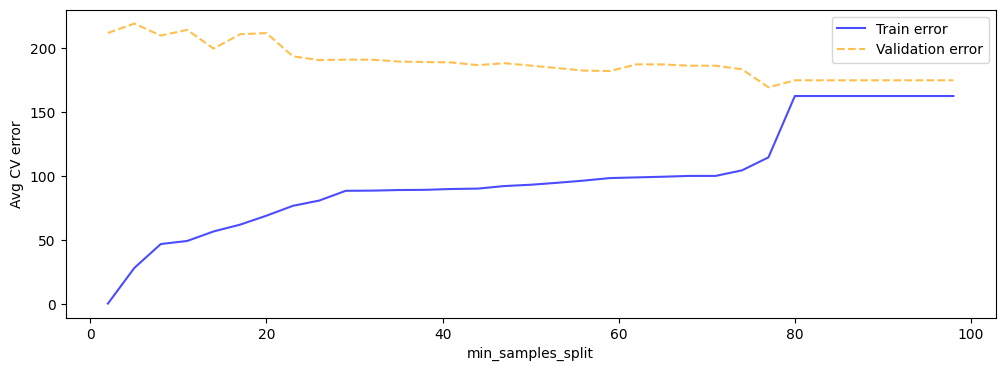

In [27]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(min_samples_split_arr, train_error_arr_min_samples_split, color='blue', alpha=0.7, label='Train error')
ax.plot(min_samples_split_arr, val_error_arr_min_samples_split, color='orange', alpha=0.7, linestyle='--', label='Validation error')
plt.legend()
ax.set_xlabel('min_samples_split')
ax.set_ylabel('Avg CV error')

plt.show()

In [28]:
#Cross Validation for max_depth of the tree
max_depth_arr = np.arange(1, 26)
train_score_error_max_depth = []
val_score_error_max_depth = []
for max_depth in max_depth_arr:
  # Conducting cross validation
  skf = KFold(n_splits=5)

  # Arrays to save errors for each fold split
  fold_train_error_arr = []
  fold_val_error_arr = []
  for i, (train_idx, val_idx) in enumerate(skf.split(X_train_word2vec, y_train_word2vec)):
    xt = X_train_word2vec[train_idx]
    yt = y_train_word2vec[train_idx]

    xv = X_train_word2vec[val_idx]
    yv = y_train_word2vec[val_idx]

    model = DecisionTreeRegressor(
        criterion='squared_error',
        random_state=42,
        max_depth=max_depth)

    # Fitting the model
    model.fit(xt, yt)

    # Getting predictions
    y_pred_train = model.predict(xt)
    y_pred_val = model.predict(xv)

    # Computing error

    # Train
    train_error = mean_squared_error(y_pred_train, yt)
    fold_train_error_arr.append(train_error)

    # Validation
    valid_error = mean_squared_error(y_pred_val, yv)
    fold_val_error_arr.append(valid_error)

  # After running all splits, we compute the avgof errors in
  # the cross-validation run
  train_score_mean = np.mean(fold_train_error_arr)
  val_score_mean = np.mean(fold_val_error_arr)

  train_score_error_max_depth.append(train_score_mean)
  val_score_error_max_depth.append(val_score_mean)

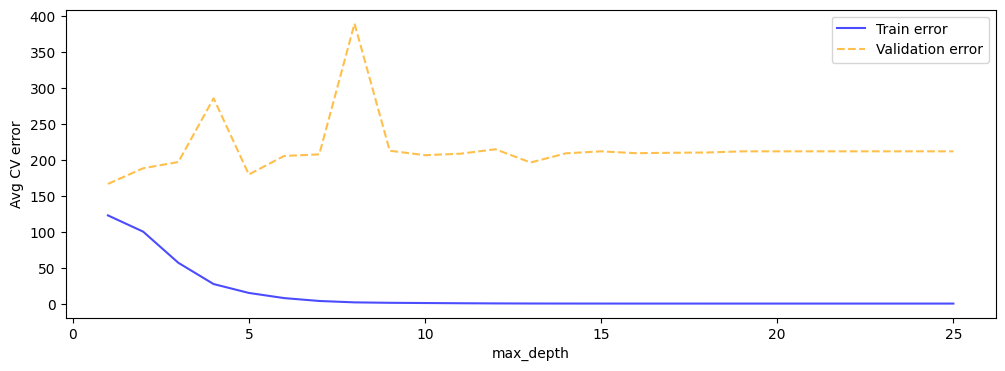

In [29]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(max_depth_arr, train_score_error_max_depth, color='blue', alpha=0.7, label='Train error')
ax.plot(max_depth_arr, val_score_error_max_depth, color='orange', alpha=0.7, linestyle='--', label='Validation error')
plt.legend()
ax.set_xlabel('max_depth')
ax.set_ylabel('Avg CV error')

plt.show()

In [125]:
#Hyper parameter search space
param_grid = {
    'max_depth': [i for i in range(6,15)],
    'min_samples_split': [j for j in range(60,75)]
}

estimator = DecisionTreeRegressor(criterion='squared_error', random_state=42)
scoring='neg_mean_squared_error'
cv = 5

grid_search_decision_tree_tune = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring=scoring,
    cv=cv
)
grid_search_decision_tree_tune.fit(X_train_word2vec, y_train_word2vec)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': [6, 7, 8, 9, 10, 11, 12, 13, 14],
                         'min_samples_split': [60, 61, 62, 63, 64, 65, 66, 67,
                                               68, 69, 70, 71, 72, 73, 74]},
             scoring='neg_mean_squared_error')

In [126]:
cols_to_include = ['param_max_depth', 'param_min_samples_split', 'mean_test_score', 'std_test_score']
results_decision_tree = pd.DataFrame(grid_search_decision_tree_tune.cv_results_)[cols_to_include]
results_decision_tree.sort_values(by='mean_test_score', ascending=False)

,param_max_depth,param_min_samples_split,mean_test_score,std_test_score
0,6,60,-181.973257,195.801372
90,12,60,-181.973257,195.801372
30,8,60,-181.973257,195.801372
45,9,60,-181.973257,195.801372
60,10,60,-181.973257,195.801372
...,...,...,...,...
107,13,62,-187.229286,206.065164
106,13,61,-187.229286,206.065164
48,9,63,-187.229286,206.065164
1,6,61,-187.229286,206.065164


In [127]:
#Use parameters that were the best from previous part
model_word2vec_tuned = DecisionTreeRegressor(
    criterion='squared_error',
    random_state=42,
    max_depth=grid_search_decision_tree_tune.best_params_['max_depth'],
    min_samples_split=grid_search_decision_tree_tune.best_params_['min_samples_split']
)

model_word2vec_tuned.fit(X_train_word2vec, y_train_word2vec)
#Test Results
y_pred_word2vec_tuned_test = model_word2vec_tuned.predict(X_test_word2vec)
#Limit the range between 0-100
for index in range(len(y_pred_word2vec_tuned_test)):
  if y_pred_word2vec_tuned_test[index] < 0:
    y_pred_word2vec_tuned_test[index] = 0
  elif y_pred_word2vec_tuned_test[index] > 100:
    y_pred_word2vec_tuned_test[index] = 100


mae_word2vec_tuned_test = mean_absolute_error(y_test_word2vec, y_pred_word2vec_tuned_test)
mse_word2vec_tuned_test = mean_squared_error(y_test_word2vec, y_pred_word2vec_tuned_test)
rmse_word2vec_tuned_test = np.sqrt(mse_word2vec_tuned_test)
r2_word2vec_tuned_test = r2_score(y_test_word2vec, y_pred_word2vec_tuned_test)

print(f"Mean Absolute Error (MAE) Test: {mae_word2vec_tuned_test}")
print(f"Mean Squared Error (MSE) Test: {mse_word2vec_tuned_test}")
print(f"Root Mean Squared Error (RMSE) Test: {rmse_word2vec_tuned_test}")
print(f"R-squared Test: {r2_word2vec_tuned_test}")
print(f"Predicted values for testing: {y_pred_word2vec_tuned_test}")
#Train Results
y_pred_word2vec_tuned_train = model_word2vec_init.predict(X_train_word2vec)
#Limit the range between 0-100
for index in range(len(y_pred_word2vec_tuned_train)):
  if y_pred_word2vec_tuned_train[index] < 0:
    y_pred_word2vec_tuned_train[index] = 0
  elif y_pred_word2vec_tuned_train[index] > 100:
    y_pred_word2vec_tuned_train[index] = 100

mae_word2vec_tuned_train = mean_absolute_error(y_train_word2vec, y_pred_word2vec_tuned_train)
mse_word2vec_tuned_train = mean_squared_error(y_train_word2vec, y_pred_word2vec_tuned_train)
rmse_word2vec_tuned_train = np.sqrt(mse_word2vec_tuned_train)
r2_word2vec_tuned_train = r2_score(y_train_word2vec, y_pred_word2vec_tuned_train)

print(f"<---------->\nMean Absolute Error (MAE) Train: {mae_word2vec_tuned_train}")
print(f"Mean Squared Error (MSE) Train: {mse_word2vec_tuned_train}")
print(f"Root Mean Squared Error (RMSE) Train: {rmse_word2vec_tuned_train}")
print(f"R-squared Train: {r2_word2vec_tuned_train}")
print(f"Predicted values for training: {y_pred_word2vec_tuned_train}")

Mean Absolute Error (MAE) Test: 6.010098870056497
Mean Squared Error (MSE) Test: 97.49985104156694
Root Mean Squared Error (RMSE) Test: 9.874201286259408
R-squared Test: 0.13152514179261543
Predicted values for testing: [96.10169492 86.4375     96.10169492 96.10169492 96.10169492 96.10169492
 96.10169492 96.10169492 96.10169492 86.4375     85.33333333 96.10169492
 96.10169492 96.10169492 96.10169492 96.10169492 96.10169492 96.10169492
 96.10169492 86.4375     96.10169492 96.10169492 86.4375     96.10169492
 86.4375    ]
<---------->
Mean Absolute Error (MAE) Train: 0.0
Mean Squared Error (MSE) Train: 0.0
Root Mean Squared Error (RMSE) Train: 0.0
R-squared Train: 1.0
Predicted values for training: [100.  51.  96.  94. 100.  84. 100.  94.  97.  85.  98.  90.  88.  99.
  99.  83.  98.  99.  86. 100. 100.  89.  84.  99. 100. 100.  75.  98.
 100.  97.  95.  95.  80. 100.  95.  99.  99.  93.  98.  90.  82.  89.
  97.  99.  97. 100.  84.  93.  96.  99.  96. 100.  99.  86.  91. 100.
  95.  85.

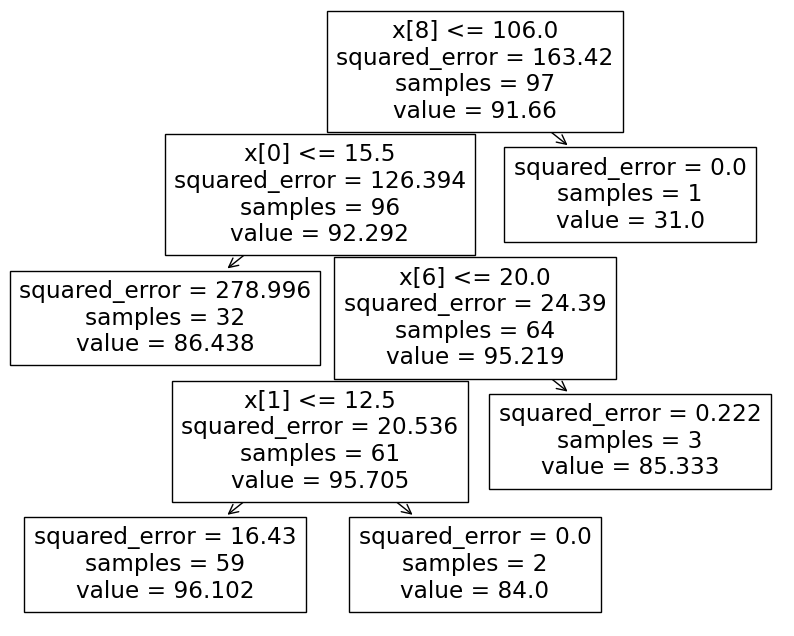

In [63]:
plt.figure(figsize=(10, 8))
plot_tree(model_word2vec_tuned)
plt.show()

###Word2vec Random Forest Regressor Model Implementation

In [98]:
#Random Forest Regressor Model
model_word2vec_init1 = RandomForestRegressor(
  criterion='squared_error',
  random_state=42)

model_word2vec_init1.fit(X_train_word2vec, y_train_word2vec)
#Test Results
y_pred_word2vec_init1_test = model_word2vec_init1.predict(X_test_word2vec)
#Limit the range between 0-100
for index in range(len(y_pred_word2vec_init1_test)):
  if y_pred_word2vec_init1_test[index] < 0:
    y_pred_word2vec_init1_test[index] = 0
  elif y_pred_word2vec_init1_test[index] > 100:
    y_pred_word2vec_init1_test[index] = 100

mae_word2vec_init1_test = mean_absolute_error(y_test_word2vec, y_pred_word2vec_init1_test)
mse_word2vec_init1_test = mean_squared_error(y_test_word2vec, y_pred_word2vec_init1_test)
rmse_word2vec_init1_test = np.sqrt(mse_word2vec_init1_test)
r2_word2vec_init1_test = r2_score(y_test_word2vec, y_pred_word2vec_init1_test)

print(f"Mean Absolute Error (MAE) Test: {mae_word2vec_init1_test}")
print(f"Mean Squared Error (MSE) Test: {mse_word2vec_init1_test}")
print(f"Root Mean Squared Error (RMSE) Test: {rmse_word2vec_init1_test}")
print(f"R-squared Test: {r2_word2vec_init1_test}")
print(f"Predicted values for testing: {y_pred_word2vec_init1_test}")

#Train Results
y_pred_word2vec_init1_train = model_word2vec_init1.predict(X_train_word2vec)
#Limit the range between 0-100
for index in range(len(y_pred_word2vec_init1_train)):
  if y_pred_word2vec_init1_train[index] < 0:
    y_pred_word2vec_init1_train[index] = 0
  elif y_pred_word2vec_init1_train[index] > 100:
    y_pred_word2vec_init1_train[index] = 100

mae_word2vec_init1_train = mean_absolute_error(y_train_word2vec, y_pred_word2vec_init1_train)
mse_word2vec_init1_train = mean_squared_error(y_train_word2vec, y_pred_word2vec_init1_train)
rmse_word2vec_init1_train = np.sqrt(mse_word2vec_init1_test)
r2_word2vec_init1_train = r2_score(y_train_word2vec, y_pred_word2vec_init1_train)

print(f"<---------->\nMean Absolute Error (MAE) Train: {mae_word2vec_init1_train}")
print(f"Mean Squared Error (MSE) Train: {mse_word2vec_init1_train}")
print(f"Root Mean Squared Error (RMSE) Train: {rmse_word2vec_init1_train}")
print(f"R-squared Train: {r2_word2vec_init1_train}")
print(f"Predicted values for training: {y_pred_word2vec_init1_train}")

Mean Absolute Error (MAE) Test: 6.3452
Mean Squared Error (MSE) Test: 109.277588
Root Mean Squared Error (RMSE) Test: 10.453592109892178
R-squared Test: 0.026615561668044352
Predicted values for testing: [96.03 90.   90.21 90.22 90.7  95.54 98.29 92.84 98.49 91.14 91.24 90.25
 96.45 94.36 95.05 94.16 97.06 93.89 94.34 91.21 83.41 94.77 92.28 94.71
 88.81]
<---------->
Mean Absolute Error (MAE) Train: 2.9596907216494843
Mean Squared Error (MSE) Train: 26.994493814432996
Root Mean Squared Error (RMSE) Train: 10.453592109892178
R-squared Train: 0.8348155838691174
Predicted values for training: [98.16 67.26 95.18 90.84 97.95 86.76 98.49 95.51 96.08 87.4  97.76 89.5
 87.68 97.24 97.76 86.48 95.88 95.68 82.85 97.34 88.96 89.82 87.73 93.62
 96.02 96.72 80.22 97.4  97.54 97.48 92.89 93.65 85.37 98.92 91.16 95.96
 96.9  93.93 95.45 91.23 85.28 90.71 93.35 96.96 96.59 95.45 86.43 92.77
 94.18 98.87 96.63 97.11 97.95 90.41 91.74 96.76 92.68 87.73 98.34 94.14
 92.33 96.46 90.76 55.1  85.7  94.49 8

In [36]:
#Cross Validation for min_samples_split of the tree
min_samples_split_arr = np.arange(2, 100, 3)

train_error_arr_min_samples_split = []
val_error_arr_min_samples_split = []
for min_samples_split in min_samples_split_arr:

  # Conducting cross validation
  skf = KFold(n_splits=5)

  # Arrays to save errors for each fold split
  fold_train_error_arr = []
  fold_val_error_arr = []
  for i, (train_idx, val_idx) in enumerate(skf.split(X_train_word2vec, y_train_word2vec)):
    xt = X_train_word2vec[train_idx]
    yt = y_train_word2vec[train_idx]

    xv = X_train_word2vec[val_idx]
    yv = y_train_word2vec[val_idx]

    model = RandomForestRegressor(
        criterion='squared_error',
        random_state=42,
        min_samples_split=min_samples_split)

    # Fitting the model
    model.fit(xt, yt)

    # Getting predictions
    y_pred_train = model.predict(xt)
    y_pred_val = model.predict(xv)

    # Computing error

    # Train
    train_error = mean_squared_error(y_pred_train, yt)
    fold_train_error_arr.append(train_error)

    # Validation
    valid_error = mean_squared_error(y_pred_val, yv)
    fold_val_error_arr.append(valid_error)

  train_score_mean = np.mean(fold_train_error_arr)
  val_score_mean = np.mean(fold_val_error_arr)

  train_error_arr_min_samples_split.append(train_score_mean)
  val_error_arr_min_samples_split.append(val_score_mean)

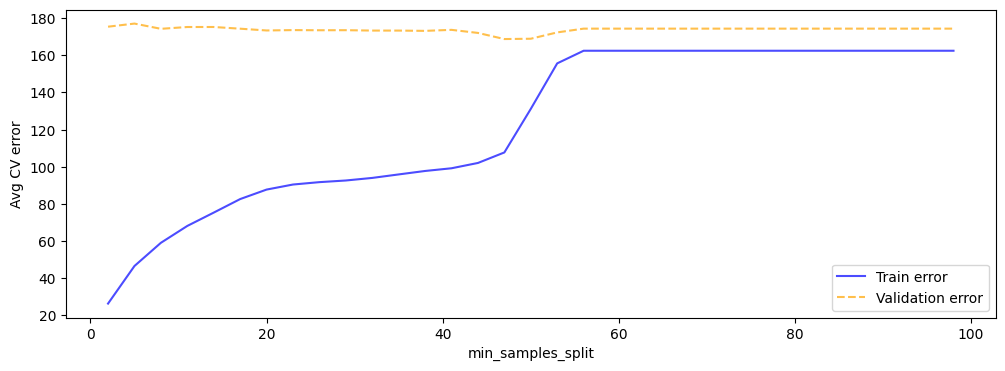

In [37]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(min_samples_split_arr, train_error_arr_min_samples_split, color='blue', alpha=0.7, label='Train error')
ax.plot(min_samples_split_arr, val_error_arr_min_samples_split, color='orange', alpha=0.7, linestyle='--', label='Validation error')
plt.legend()
ax.set_xlabel('min_samples_split')
ax.set_ylabel('Avg CV error')

plt.show()

In [38]:
#Cross Validation for max_depth of the tree
max_depth_arr = np.arange(1, 26)
train_score_error_max_depth = []
val_score_error_max_depth = []
for max_depth in max_depth_arr:
  skf = KFold(n_splits=5)

  fold_train_error_arr = []
  fold_val_error_arr = []
  for i, (train_idx, val_idx) in enumerate(skf.split(X_train_word2vec, y_train_word2vec)):
    xt = X_train_word2vec[train_idx]
    yt = y_train_word2vec[train_idx]

    xv = X_train_word2vec[val_idx]
    yv = y_train_word2vec[val_idx]

    model = RandomForestRegressor(
        criterion='squared_error',
        random_state=42,
        max_depth=max_depth)

    # Fitting the model
    model.fit(xt, yt)

    # Getting predictions
    y_pred_train = model.predict(xt)
    y_pred_val = model.predict(xv)

    # Computing accuracy

    # Train
    train_error = mean_squared_error(y_pred_train, yt)
    fold_train_error_arr.append(train_error)

    # Validation
    valid_error = mean_squared_error(y_pred_val, yv)
    fold_val_error_arr.append(valid_error)

  train_score_mean = np.mean(fold_train_error_arr)
  val_score_mean = np.mean(fold_val_error_arr)

  train_score_error_max_depth.append(train_score_mean)
  val_score_error_max_depth.append(val_score_mean)

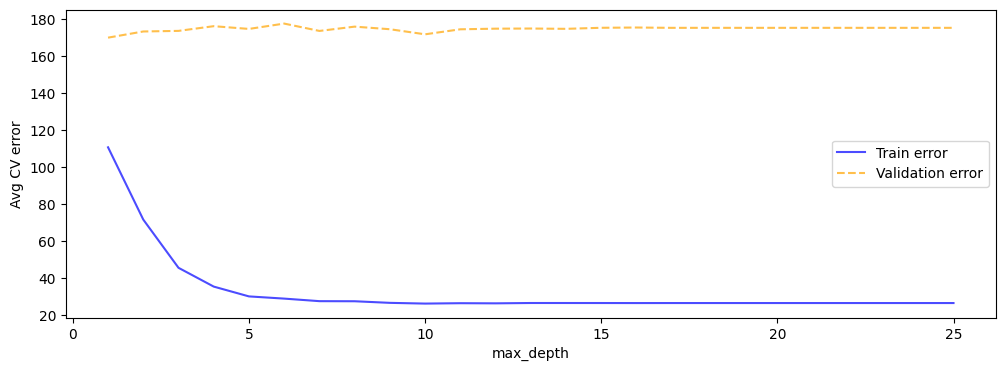

In [39]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(max_depth_arr, train_score_error_max_depth, color='blue', alpha=0.7, label='Train error')
ax.plot(max_depth_arr, val_score_error_max_depth, color='orange', alpha=0.7, linestyle='--', label='Validation error')
plt.legend()
ax.set_xlabel('max_depth')
ax.set_ylabel('Avg CV error')

plt.show()

In [129]:
param_grid = {
    'max_depth': [i for i in range(10,18)],
    'min_samples_split': [j for j in range(40,62)],
}

estimator = RandomForestRegressor(criterion='squared_error', random_state=42)
scoring='neg_mean_squared_error'
cv = 5

grid_search_randomforest_tune = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring=scoring,
    cv=cv
)
grid_search_randomforest_tune.fit(X_train_word2vec, y_train_word2vec)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [10, 11, 12, 13, 14, 15, 16, 17],
                         'min_samples_split': [40, 41, 42, 43, 44, 45, 46, 47,
                                               48, 49, 50, 51, 52, 53, 54, 55,
                                               56, 57, 58, 59, 60, 61]},
             scoring='neg_mean_squared_error')

In [130]:
cols_to_include = ['param_max_depth', 'param_min_samples_split', 'mean_test_score', 'std_test_score']
results = pd.DataFrame(grid_search_randomforest_tune.cv_results_)[cols_to_include]
results.sort_values(by='mean_test_score', ascending=False)

,param_max_depth,param_min_samples_split,mean_test_score,std_test_score
141,16,49,-166.891622,209.295501
53,12,49,-166.891622,209.295501
97,14,49,-166.891622,209.295501
119,15,49,-166.891622,209.295501
9,10,49,-166.891622,209.295501
...,...,...,...,...
39,11,57,-174.368535,220.367622
38,11,56,-174.368535,220.367622
37,11,55,-174.368535,220.367622
106,14,58,-174.368535,220.367622


In [132]:
model_word2vec_tuned1 = RandomForestRegressor(
    criterion='squared_error',
    random_state=42,
    max_depth=grid_search_randomforest_tune.best_params_['max_depth'],
    min_samples_split=grid_search_randomforest_tune.best_params_['min_samples_split'],
    n_estimators = 1000
)
model_word2vec_tuned1.fit(X_train_word2vec, y_train_word2vec)
#Test Results
y_pred_word2vec_tuned1_test = model_word2vec_tuned1.predict(X_test_word2vec)
#Limit the range between 0-100
for index in range(len(y_pred_word2vec_tuned1_test)):
  if y_pred_word2vec_tuned1_test[index] < 0:
    y_pred_word2vec_tuned1_test[index] = 0
  elif y_pred_word2vec_tuned1_test[index] > 100:
    y_pred_word2vec_tuned1_test[index] = 100

mae_word2vec_tuned1_test = mean_absolute_error(y_test_word2vec, y_pred_word2vec_tuned1_test)
mse_word2vec_tuned1_test = mean_squared_error(y_test_word2vec, y_pred_word2vec_tuned1_test)
rmse_word2vec_tuned1_test = np.sqrt(mse_word2vec_tuned1_test)
r2_word2vec_tuned1_test = r2_score(y_test_word2vec, y_pred_word2vec_tuned1_test)

print(f"Mean Absolute Error (MAE) Test: {mae_word2vec_tuned1_test}")
print(f"Mean Squared Error (MSE) Test: {mse_word2vec_tuned1_test}")
print(f"Root Mean Squared Error (RMSE) Test: {rmse_word2vec_tuned1_test}")
print(f"R-squared Test: {r2_word2vec_tuned1_test}")
print(f"Predicted values for testing: {y_pred_word2vec_tuned1_test}")
#Train Results
y_pred_word2vec_tuned1_train = model_word2vec_init1.predict(X_train_word2vec)
#Limit the range between 0-100
for index in range(len(y_pred_word2vec_tuned1_train)):
  if y_pred_word2vec_tuned1_train[index] < 0:
    y_pred_word2vec_tuned1_train[index] = 0
  elif y_pred_word2vec_tuned1_train[index] > 100:
    y_pred_word2vec_tuned1_train[index] = 100

mae_word2vec_tuned1_train = mean_absolute_error(y_train_word2vec, y_pred_word2vec_tuned1_train)
mse_word2vec_tuned1_train = mean_squared_error(y_train_word2vec, y_pred_word2vec_tuned1_train)
rmse_word2vec_tuned1_train = np.sqrt(mse_word2vec_init1_train)
r2_word2vec_tuned1_train = r2_score(y_train_word2vec, y_pred_word2vec_tuned1_train)

print(f"<---------->\nMean Absolute Error (MAE) Train: {mae_word2vec_tuned1_train}")
print(f"Mean Squared Error (MSE) Train: {mse_word2vec_tuned1_train}")
print(f"Root Mean Squared Error (RMSE) Train: {rmse_word2vec_tuned1_train}")
print(f"R-squared Train: {r2_word2vec_tuned1_train}")
print(f"Predicted values for training: {y_pred_word2vec_tuned1_train}")


Mean Absolute Error (MAE) Test: 6.613946268798774
Mean Squared Error (MSE) Test: 101.53198013300198
Root Mean Squared Error (RMSE) Test: 10.076307862158737
R-squared Test: 0.09560916137265574
Predicted values for testing: [93.93234282 87.39745756 86.24334967 92.62236759 94.90439706 94.04149139
 95.42348731 94.25539894 95.50044469 83.68689516 94.59062835 85.91550454
 95.43346121 94.31705364 95.24766268 94.63372556 94.48803522 94.29641199
 93.15540217 86.82090245 85.5067657  95.18985556 88.32810683 95.22587459
 92.35091127]
<---------->
Mean Absolute Error (MAE) Train: 2.9596907216494843
Mean Squared Error (MSE) Train: 26.994493814432996
Root Mean Squared Error (RMSE) Train: 5.1956225627380785
R-squared Train: 0.8348155838691174
Predicted values for training: [98.16 67.26 95.18 90.84 97.95 86.76 98.49 95.51 96.08 87.4  97.76 89.5
 87.68 97.24 97.76 86.48 95.88 95.68 82.85 97.34 88.96 89.82 87.73 93.62
 96.02 96.72 80.22 97.4  97.54 97.48 92.89 93.65 85.37 98.92 91.16 95.96
 96.9  93.93 9

###Word2vec Gradient Boosting Regressor Model Implementation

In [104]:
model_word2vec_init2 = GradientBoostingRegressor(criterion = 'squared_error',learning_rate=0.1, random_state=42)
model_word2vec_init2.fit(X_train_word2vec, y_train_word2vec)
#Test Results
y_pred_word2vec_init2_test = model_word2vec_init2.predict(X_test_word2vec)
for index in range(len(y_pred_word2vec_init2_test)):
  if y_pred_word2vec_init2_test[index] < 0:
    y_pred_word2vec_init2_test[index] = 0
  elif y_pred_word2vec_init2_test[index] > 100:
    y_pred_word2vec_init2_test[index] = 100

mae_word2vec_init2_test = mean_absolute_error(y_test_word2vec, y_pred_word2vec_init2_test)
mse_word2vec_init2_test = mean_squared_error(y_test_word2vec, y_pred_word2vec_init2_test)
rmse_word2vec_init2_test = np.sqrt(mse_word2vec_init2_test)
r2_word2vec_init2_test = r2_score(y_test_word2vec, y_pred_word2vec_init2_test)

print(f"Mean Absolute Error (MAE) Test: {mae_word2vec_init2_test}")
print(f"Mean Squared Error (MSE) Test: {mse_word2vec_init2_test}")
print(f"Root Mean Squared Error (RMSE) Test: {rmse_word2vec_init2_test}")
print(f"R-squared Test: {r2_word2vec_init2_test}")
print(f"Predicted values for testing: {y_pred_word2vec_init2_test}")

#Train Results
y_pred_word2vec_init2_train = model_word2vec_init2.predict(X_train_word2vec)
for index in range(len(y_pred_word2vec_init2_train)):
  if y_pred_word2vec_init2_train[index] < 0:
    y_pred_word2vec_init2_train[index] = 0
  elif y_pred_word2vec_init2_train[index] > 100:
    y_pred_word2vec_init2_train[index] = 100

mae_word2vec_init2_train = mean_absolute_error(y_train_word2vec, y_pred_word2vec_init2_train)
mse_word2vec_init2_train = mean_squared_error(y_train_word2vec, y_pred_word2vec_init2_train)
rmse_word2vec_init2_train = np.sqrt(mse_word2vec_init2_train)
r2_word2vec_init2_train = r2_score(y_train_word2vec, y_pred_word2vec_init2_train)

print(f"<---------->\nMean Absolute Error (MAE) Train: {mae_word2vec_init2_train}")
print(f"Mean Squared Error (MSE) Train: {mse_word2vec_init2_train}")
print(f"Root Mean Squared Error (RMSE) Train: {rmse_word2vec_init2_train}")
print(f"R-squared Train: {r2_word2vec_init2_train}")
print(f"Predicted values for training: {y_pred_word2vec_init2_train}")

Mean Absolute Error (MAE) Test: 5.538478987207515
Mean Squared Error (MSE) Test: 75.88773314329794
Root Mean Squared Error (RMSE) Test: 8.71135656159808
R-squared Test: 0.3240339592600232
Predicted values for testing: [98.54108708 94.27911932 92.80543468 94.59050342 92.29027168 98.65463327
 98.89007226 93.52931728 99.09291072 94.64383681 90.3168314  97.15813298
 97.79105641 95.55913337 97.90828279 96.83698158 99.87994717 96.71640925
 94.20999566 80.32770803 93.13265393 98.9092088  96.58574618 93.75259474
 90.17498968]
<---------->
Mean Absolute Error (MAE) Train: 0.990143113887331
Mean Squared Error (MSE) Train: 1.50310068410822
Root Mean Squared Error (RMSE) Train: 1.226010066886981
R-squared Train: 0.9908022424648097
Predicted values for training: [98.89007226 53.5128396  96.43131095 94.2930334  98.76918992 84.38210015
 99.05007158 95.46966357 96.32731203 85.72899465 98.57487277 89.81945284
 87.78002619 97.52448184 98.70847237 84.76523237 97.71974319 96.45221979
 86.35858611 98.88776

In [44]:
min_samples_split_arr = np.arange(2, 100, 3)

train_error_arr_min_samples_split = []
val_error_arr_min_samples_split = []
for min_samples_split in min_samples_split_arr:
  skf = KFold(n_splits=5)

  fold_train_error_arr = []
  fold_val_error_arr = []
  for i, (train_idx, val_idx) in enumerate(skf.split(X_train_word2vec, y_train_word2vec)):
    xt = X_train_word2vec[train_idx]
    yt = y_train_word2vec[train_idx]

    xv = X_train_word2vec[val_idx]
    yv = y_train_word2vec[val_idx]

    model = GradientBoostingRegressor(
        criterion='squared_error',
        random_state=42,
        min_samples_split=min_samples_split)

    # Fitting the model
    model.fit(xt, yt)

    # Getting predictions
    y_pred_train = model.predict(xt)
    y_pred_val = model.predict(xv)

    # Computing error

    # Train
    train_error = mean_squared_error(y_pred_train, yt)
    fold_train_error_arr.append(train_error)

    # Validation
    valid_error = mean_squared_error(y_pred_val, yv)
    fold_val_error_arr.append(valid_error)


  train_score_mean = np.mean(fold_train_error_arr)
  val_score_mean = np.mean(fold_val_error_arr)

  train_error_arr_min_samples_split.append(train_score_mean)
  val_error_arr_min_samples_split.append(val_score_mean)

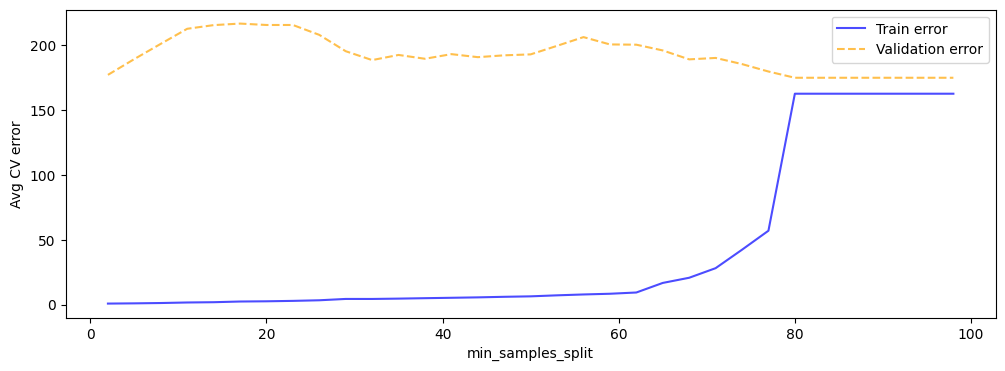

In [45]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(min_samples_split_arr, train_error_arr_min_samples_split, color='blue', alpha=0.7, label='Train error')
ax.plot(min_samples_split_arr, val_error_arr_min_samples_split, color='orange', alpha=0.7, linestyle='--', label='Validation error')
plt.legend()
ax.set_xlabel('min_samples_split')
ax.set_ylabel('Avg CV error')

plt.show()

In [46]:
max_depth_arr = np.arange(1, 26)
train_score_error_max_depth = []
val_score_error_max_depth = []
for max_depth in max_depth_arr:
  # Conducting cross validation
  skf = KFold(n_splits=5)

  # Arrays to save accuracies for each fold split
  fold_train_error_arr = []
  fold_val_error_arr = []
  for i, (train_idx, val_idx) in enumerate(skf.split(X_train_word2vec, y_train_word2vec)):
    xt = X_train_word2vec[train_idx]
    yt = y_train_word2vec[train_idx]

    xv = X_train_word2vec[val_idx]
    yv = y_train_word2vec[val_idx]

    model = GradientBoostingRegressor(
        criterion='squared_error',
        random_state=42,
        max_depth=max_depth)

    # Fitting the model
    model.fit(xt, yt)

    # Getting predictions
    y_pred_train = model.predict(xt)
    y_pred_val = model.predict(xv)

    # Computing accuracy

    # Train
    train_error = mean_squared_error(y_pred_train, yt)
    fold_train_error_arr.append(train_error)

    # Validation
    valid_error = mean_squared_error(y_pred_val, yv)
    fold_val_error_arr.append(valid_error)

  train_score_mean = np.mean(fold_train_error_arr)
  val_score_mean = np.mean(fold_val_error_arr)

  train_score_error_max_depth.append(train_score_mean)
  val_score_error_max_depth.append(val_score_mean)

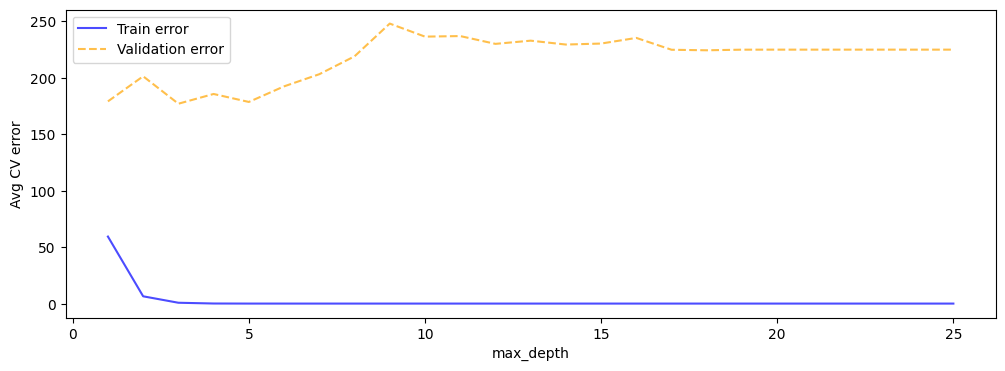

In [47]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(max_depth_arr, train_score_error_max_depth, color='blue', alpha=0.7, label='Train error')
ax.plot(max_depth_arr, val_score_error_max_depth, color='orange', alpha=0.7, linestyle='--', label='Validation error')
plt.legend()
ax.set_xlabel('max_depth')
ax.set_ylabel('Avg CV error')

plt.show()

In [133]:
param_grid = {
    'max_depth': [i for i in range(3,16)],
    'min_samples_split': [j for j in range(60,81)]
}

estimator = GradientBoostingRegressor(criterion='squared_error', random_state=42)
scoring='neg_mean_squared_error'
cv = 5

grid_search_gradient_boosting_tune = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring=scoring,
    cv=cv
)
grid_search_gradient_boosting_tune.fit(X_train_word2vec, y_train_word2vec)

GridSearchCV(cv=5,
             estimator=GradientBoostingRegressor(criterion='squared_error',
                                                 random_state=42),
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                       15],
                         'min_samples_split': [60, 61, 62, 63, 64, 65, 66, 67,
                                               68, 69, 70, 71, 72, 73, 74, 75,
                                               76, 77, 78, 79, 80]},
             scoring='neg_mean_squared_error')

In [135]:
cols_to_include = ['param_max_depth', 'param_min_samples_split', 'mean_test_score', 'std_test_score']
results = pd.DataFrame(grid_search_gradient_boosting_tune.cv_results_)[cols_to_include]
results.sort_values(by='mean_test_score', ascending=False)

,param_max_depth,param_min_samples_split,mean_test_score,std_test_score
102,7,78,-174.629120,227.795617
186,11,78,-174.629120,227.795617
207,12,78,-174.629120,227.795617
123,8,78,-174.629120,227.795617
18,3,78,-174.629120,227.795617
...,...,...,...,...
69,6,66,-208.789861,207.305313
111,8,66,-208.789861,207.305313
48,5,66,-209.206572,207.277224
4,3,64,-209.374401,204.612753


In [136]:
model_word2vec_tuned2 = GradientBoostingRegressor(
    criterion='squared_error',
    random_state=42,
    max_depth=grid_search_gradient_boosting_tune.best_params_['max_depth'],
    min_samples_split=grid_search_gradient_boosting_tune.best_params_['min_samples_split'],
    n_estimators = 1000
)
model_word2vec_tuned2.fit(X_train_word2vec, y_train_word2vec)
#Test Results
y_pred_word2vec_tuned2_test = model_word2vec_tuned2.predict(X_test_word2vec)
for index in range(len(y_pred_word2vec_tuned2_test)):
  if y_pred_word2vec_tuned2_test[index] < 0:
    y_pred_word2vec_tuned2_test[index] = 0
  elif y_pred_word2vec_tuned2_test[index] > 100:
    y_pred_word2vec_tuned2_test[index] = 100

mae_word2vec_tuned2_test = mean_absolute_error(y_test_word2vec, y_pred_word2vec_tuned2_test)
mse_word2vec_tuned2_test = mean_squared_error(y_test_word2vec, y_pred_word2vec_tuned2_test)
rmse_word2vec_tuned2_test = np.sqrt(mse_word2vec_tuned2_test)
r2_word2vec_tuned2_test = r2_score(y_test_word2vec, y_pred_word2vec_tuned2_test)

print(f"Mean Absolute Error (MAE) Test: {mae_word2vec_tuned2_test}")
print(f"Mean Squared Error (MSE) Test: {mse_word2vec_tuned2_test}")
print(f"Root Mean Squared Error (RMSE) Test: {rmse_word2vec_tuned2_test}")
print(f"R-squared Test: {r2_word2vec_tuned2_test}")
print(f"Predicted values for testing: {y_pred_word2vec_tuned2_test}")
#Train Results
y_pred_word2vec_tuned2_train = model_word2vec_tuned2.predict(X_train_word2vec)
for index in range(len(y_pred_word2vec_tuned2_train)):
  if y_pred_word2vec_tuned2_train[index] < 0:
    y_pred_word2vec_tuned2_train[index] = 0
  elif y_pred_word2vec_tuned2_train[index] > 100:
    y_pred_word2vec_tuned2_train[index] = 100

mae_word2vec_tuned2_train = mean_absolute_error(y_train_word2vec, y_pred_word2vec_tuned2_train)
mse_word2vec_tuned2_train = mean_squared_error(y_train_word2vec, y_pred_word2vec_tuned2_train)
rmse_word2vec_tuned2_train = np.sqrt(mse_word2vec_tuned2_train)
r2_word2vec_tuned2_train = r2_score(y_train_word2vec, y_pred_word2vec_tuned2_train)

print(f"<---------->\nMean Absolute Error (MAE) Train: {mae_word2vec_tuned2_train}")
print(f"Mean Squared Error (MSE) Train: {mse_word2vec_tuned2_train}")
print(f"Root Mean Squared Error (RMSE) Train: {rmse_word2vec_tuned2_train}")
print(f"R-squared Train: {r2_word2vec_tuned2_train}")
print(f"Predicted values for training: {y_pred_word2vec_tuned2_train}")

Mean Absolute Error (MAE) Test: 6.791954270208678
Mean Squared Error (MSE) Test: 121.27218638360996
Root Mean Squared Error (RMSE) Test: 11.01236515847572
R-squared Test: -0.0802257003357214
Predicted values for testing: [100.          89.49704952  79.59494115  92.62995586  93.72690334
 100.          99.42609212  88.07179938 100.          97.80680391
  94.80443949  97.39263911 100.          93.70828155 100.
  98.23247083 100.          97.89209667  93.07127966  90.60421924
  89.49840847 100.          99.42354253  95.7519686   84.94630655]
<---------->
Mean Absolute Error (MAE) Train: 0.3450466338538247
Mean Squared Error (MSE) Train: 0.2129815615738159
Root Mean Squared Error (RMSE) Train: 0.46149925414220977
R-squared Train: 0.998696725519765
Predicted values for training: [ 99.58540043  51.93374609  95.83875495  93.65539925  99.65910975
  83.93575183  99.73100369  94.51592919  97.17023883  85.26725815
  98.33570327  89.39760777  87.85901965  98.43229923  99.3603827
  83.93673749  97.9

###Word2vec XGBoost Regressor Model Implementation

In [112]:
model_word2vec_init3 = xgb.XGBRegressor()
model_word2vec_init3.fit(X_train_word2vec, y_train_word2vec)
#Test Results
y_pred_word2vec_init3_test = model_word2vec_init3.predict(X_test_word2vec)
for index in range(len(y_pred_word2vec_init3_test)):
  if y_pred_word2vec_init3_test[index] < 0:
    y_pred_word2vec_init3_test[index] = 0
  elif y_pred_word2vec_init3_test[index] > 100:
    y_pred_word2vec_init3_test[index] = 100


mae_word2vec_init3_test = mean_absolute_error(y_test_word2vec, y_pred_word2vec_init3_test)
mse_word2vec_init3_test = mean_squared_error(y_test_word2vec, y_pred_word2vec_init3_test)
rmse_word2vec_init3_test = np.sqrt(mse_word2vec_init3_test)
r2_word2vec_init3_test = r2_score(y_test_word2vec, y_pred_word2vec_init3_test)

print(f"Mean Absolute Error (MAE) Test: {mae_word2vec_init3_test}")
print(f"Mean Squared Error (MSE) Test: {mse_word2vec_init3_test}")
print(f"Root Mean Squared Error (RMSE) Test: {rmse_word2vec_init3_test}")
print(f"R-squared Test: {r2_word2vec_init3_test}")
print(f"Predicted values for testing: {y_pred_word2vec_init3_test}")
#Train Results
y_pred_word2vec_init3_train = model_word2vec_init3.predict(X_train_word2vec)
for index in range(len(y_pred_word2vec_init3_train)):
  if y_pred_word2vec_init3_train[index] < 0:
    y_pred_word2vec_init3_train[index] = 0
  elif y_pred_word2vec_init3_train[index] > 100:
    y_pred_word2vec_init3_train[index] = 100


mae_word2vec_init3_train = mean_absolute_error(y_train_word2vec, y_pred_word2vec_init3_train)
mse_word2vec_init3_train = mean_squared_error(y_train_word2vec, y_pred_word2vec_init3_train)
rmse_word2vec_init3_train = np.sqrt(mse_word2vec_init3_train)
r2_word2vec_init3_train = r2_score(y_train_word2vec, y_pred_word2vec_init3_train)

print(f"<---------->\nMean Absolute Error (MAE) Train: {mae_word2vec_init3_train}")
print(f"Mean Squared Error (MSE) Train: {mse_word2vec_init3_train}")
print(f"Root Mean Squared Error (RMSE) Train: {rmse_word2vec_init3_train}")
print(f"R-squared Train: {r2_word2vec_init3_train}")
print(f"Predicted values for training: {y_pred_word2vec_init3_train}")

Mean Absolute Error (MAE) Test: 6.288366088867187
Mean Squared Error (MSE) Test: 92.45313066481613
Root Mean Squared Error (RMSE) Test: 9.615255101390504
R-squared Test: 0.17647854138029695
Predicted values for testing: [98.64416  91.53681  90.60453  84.05456  87.82555  98.16857  99.0715
 94.541885 99.024956 96.63369  92.49579  92.91136  95.49574  97.368416
 95.733894 95.664215 98.50634  96.45265  94.309784 83.06278  95.70866
 94.97141  96.11814  94.44712  90.349724]
<---------->
Mean Absolute Error (MAE) Train: 0.000463977302472616
Mean Squared Error (MSE) Train: 4.059375268551185e-07
Root Mean Squared Error (RMSE) Train: 0.0006371322679437281
R-squared Train: 0.9999999975159914
Predicted values for training: [ 99.99995    51.001377   95.999886   94.00012    99.99923    83.99981
  99.998505   94.00047    96.99935    85.000404   97.999825   90.00017
  87.9998     99.00031    99.000206   83.00012    97.99983    98.99912
  86.00026    99.999405   99.99971    89.0002     84.00089    98.99

In [137]:
param_grid = {
    'max_depth': [3,6,10],
    'n_estimators': [100,150,200,250,300,500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5, 1],
    'colsample_bytree': [0.3, 0.55, 0.7]
}

estimator = xgb.XGBRegressor()
scoring='neg_mean_squared_error'
cv = 5

grid_search_XGBoost_tune = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring=scoring,
    cv=cv,
    verbose=1
)
grid_search_XGBoost_tune.fit(X_train_word2vec, y_train_word2vec)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.55, 0.7],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5, 1],
                         'max_depth': [3, 6, 10],
                         'n_estimators': [100, 150, 200, 250, 300, 500]},
             scoring='neg_mean_squared_error', verbose=1)

In [138]:
cols_to_include = ['param_max_depth', 'param_n_estimators','param_learning_rate','param_colsample_bytree','mean_test_score', 'std_test_score']
results = pd.DataFrame(grid_search_XGBoost_tune.cv_results_)[cols_to_include]
results.sort_values(by='mean_test_score', ascending=False)

,param_max_depth,param_n_estimators,param_learning_rate,param_colsample_bytree,mean_test_score,std_test_score
120,10,100,0.01,0.55,-167.355407,210.871715
121,10,150,0.01,0.55,-167.811736,207.671662
114,6,100,0.01,0.55,-168.205681,213.493242
115,6,150,0.01,0.55,-168.234894,209.786426
12,10,100,0.01,0.3,-168.934065,220.925795
...,...,...,...,...,...,...
100,6,300,1,0.3,-313.741947,200.553911
99,6,250,1,0.3,-313.741947,200.553911
98,6,200,1,0.3,-313.741947,200.553911
97,6,150,1,0.3,-313.741947,200.553911


In [139]:
model_word2vec_tuned3 = xgb.XGBRegressor(
    max_depth = grid_search_XGBoost_tune.best_params_['max_depth'],
    n_estimators = grid_search_XGBoost_tune.best_params_['n_estimators'],
    learning_rate = grid_search_XGBoost_tune.best_params_['learning_rate'],
    colsample_bytree = grid_search_XGBoost_tune.best_params_['colsample_bytree']
)
model_word2vec_tuned3.fit(X_train_word2vec, y_train_word2vec)
#Test Results
y_pred_word2vec_tuned3_test = model_word2vec_tuned3.predict(X_test_word2vec)
for index in range(len(y_pred_word2vec_tuned3_test)):
  if y_pred_word2vec_tuned3_test[index] < 0:
    y_pred_word2vec_tuned3_test[index] = 0
  elif y_pred_word2vec_tuned3_test[index] > 100:
    y_pred_word2vec_tuned3_test[index] = 100

mae_word2vec_tuned3_test = mean_absolute_error(y_test_word2vec, y_pred_word2vec_tuned3_test)
mse_word2vec_tuned3_test = mean_squared_error(y_test_word2vec, y_pred_word2vec_tuned3_test)
rmse_word2vec_tuned3_test = np.sqrt(mse_word2vec_tuned3_test)
r2_word2vec_tuned3_test = r2_score(y_test_word2vec, y_pred_word2vec_tuned3_test)

print(f"Mean Absolute Error (MAE) Test: {mae_word2vec_tuned3_test}")
print(f"Mean Squared Error (MSE) Test: {mse_word2vec_tuned3_test}")
print(f"Root Mean Squared Error (RMSE) Test: {rmse_word2vec_tuned3_test}")
print(f"R-squared Test: {r2_word2vec_tuned3_test}")
print(f"Predicted values for testing: {y_pred_word2vec_tuned3_test}")
#Train Results
y_pred_word2vec_tuned3_train = model_word2vec_tuned3.predict(X_train_word2vec)
for index in range(len(y_pred_word2vec_tuned3_train)):
  if y_pred_word2vec_tuned3_train[index] < 0:
    y_pred_word2vec_tuned3_train[index] = 0
  elif y_pred_word2vec_tuned3_train[index] > 100:
    y_pred_word2vec_tuned3_train[index] = 100


mae_word2vec_tuned3_train = mean_absolute_error(y_train_word2vec, y_pred_word2vec_tuned3_train)
mse_word2vec_tuned3_train = mean_squared_error(y_train_word2vec, y_pred_word2vec_tuned3_train)
rmse_word2vec_tuned3_train = np.sqrt(mse_word2vec_tuned3_train)
r2_word2vec_tuned3_train = r2_score(y_train_word2vec, y_pred_word2vec_tuned3_train)

print(f"<---------->\nMean Absolute Error (MAE) Train: {mae_word2vec_tuned3_train}")
print(f"Mean Squared Error (MSE) Train: {mse_word2vec_tuned3_train}")
print(f"Root Mean Squared Error (RMSE) Train: {rmse_word2vec_tuned3_train}")
print(f"R-squared Train: {r2_word2vec_tuned3_train}")
print(f"Predicted values for training: {y_pred_word2vec_tuned3_train}")

Mean Absolute Error (MAE) Test: 6.127607421875
Mean Squared Error (MSE) Test: 98.9280321222404
Root Mean Squared Error (RMSE) Test: 9.946257191639496
R-squared Test: 0.11880369300800597
Predicted values for testing: [94.841034 90.53434  92.69211  90.51448  90.88584  95.05922  96.07161
 93.612946 95.88728  93.63851  93.173195 93.68532  93.73877  93.96551
 93.63364  93.46053  95.463936 93.575584 92.51818  88.86376  92.62946
 93.71795  92.90259  93.68226  90.3704  ]
<---------->
Mean Absolute Error (MAE) Train: 3.7225578544066122
Mean Squared Error (MSE) Train: 51.79818239337921
Root Mean Squared Error (RMSE) Train: 7.1970954136637095
R-squared Train: 0.6830371195655988
Predicted values for training: [96.07022  73.6442   94.44634  92.99032  96.05501  87.88384  96.10056
 94.65077  95.46003  88.2125   95.86396  90.68216  89.72519  95.53176
 95.87243  87.20592  95.52259  95.7826   88.907104 95.537155 95.78064
 90.140114 88.22709  95.11555  95.84615  95.544624 82.64319  95.80712
 96.01571  95

###Word2vec CatBoost Regression Implementation

In [117]:
model_word2vec_init4 = CatBoostRegressor(verbose=0)
model_word2vec_init4.fit(X_train_word2vec, y_train_word2vec)
#Test Results
y_pred_word2vec_init4_test = model_word2vec_init4.predict(X_test_word2vec)
for index in range(len(y_pred_word2vec_init4_test)):
  if y_pred_word2vec_init4_test[index] < 0:
    y_pred_word2vec_init4_test[index] = 0
  elif y_pred_word2vec_init4_test[index] > 100:
    y_pred_word2vec_init4_test[index] = 100

mae_word2vec_init4_test = mean_absolute_error(y_test_word2vec, y_pred_word2vec_init4_test)
mse_word2vec_init4_test = mean_squared_error(y_test_word2vec, y_pred_word2vec_init4_test)
rmse_word2vec_init4_test = np.sqrt(mse_word2vec_init4_test)
r2_word2vec_init4_test = r2_score(y_test_word2vec, y_pred_word2vec_init4_test)

print(f"Mean Absolute Error (MAE) Test: {mae_word2vec_init4_test}")
print(f"Mean Squared Error (MSE) Test: {mse_word2vec_init4_test}")
print(f"Root Mean Squared Error (RMSE) Test: {rmse_word2vec_init4_test}")
print(f"R-squared Test: {r2_word2vec_init4_test}")
print(f"Predicted values for testing: {y_pred_word2vec_init4_test}")

#Train Results
y_pred_word2vec_init4_train = model_word2vec_init4.predict(X_train_word2vec)
for index in range(len(y_pred_word2vec_init4_train)):
  if y_pred_word2vec_init4_train[index] < 0:
    y_pred_word2vec_init4_train[index] = 0
  elif y_pred_word2vec_init4_train[index] > 100:
    y_pred_word2vec_init4_train[index] = 100

mae_word2vec_init4_train = mean_absolute_error(y_train_word2vec, y_pred_word2vec_init4_train)
mse_word2vec_init4_train = mean_squared_error(y_train_word2vec, y_pred_word2vec_init4_train)
rmse_word2vec_init4_train = np.sqrt(mse_word2vec_init4_train)
r2_word2vec_init4_train = r2_score(y_train_word2vec, y_pred_word2vec_init4_train)

print(f"<---------->\nMean Absolute Error (MAE) Train: {mae_word2vec_init4_train}")
print(f"Mean Squared Error (MSE) Train: {mse_word2vec_init4_train}")
print(f"Root Mean Squared Error (RMSE) Train: {rmse_word2vec_init4_train}")
print(f"R-squared Train: {r2_word2vec_init4_train}")
print(f"Predicted values for training: {y_pred_word2vec_init4_train}")

Mean Absolute Error (MAE) Test: 6.256039935831259
Mean Squared Error (MSE) Test: 93.66483408311323
Root Mean Squared Error (RMSE) Test: 9.678059417213413
R-squared Test: 0.16568535612767188
Predicted values for testing: [92.37442019 90.61853403 90.28121052 82.11499763 94.99880529 95.78249863
 98.42196072 93.01895177 97.96041697 97.50276026 91.19899205 95.30800988
 97.28931872 96.25857199 96.91358546 95.92149202 97.60342323 93.29090152
 94.65024745 85.72400158 92.17380437 96.35183453 93.37515493 91.56563731
 90.62254378]
<---------->
Mean Absolute Error (MAE) Train: 0.2011382221594609
Mean Squared Error (MSE) Train: 0.06308302547756894
Root Mean Squared Error (RMSE) Train: 0.2511633442156099
R-squared Train: 0.999613983029172
Predicted values for training: [99.58848013 51.68813695 95.84966501 93.81819189 99.70966403 84.09220507
 99.74608142 94.37347032 96.78645074 85.19565114 98.0623674  89.90205005
 88.07665246 98.63041279 99.14154333 83.24855614 97.95420346 98.76475222
 86.07519272 99

In [140]:
param_grid = {
  'depth': [x for x in range(0,10)],
  'learning_rate': [0.01, 0.05, 1]
}

estimator = CatBoostRegressor(verbose=0)
scoring='neg_mean_squared_error'
cv = 5

grid_search_CatBoost_tune = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring=scoring,
    cv=cv,
    verbose=1
)
grid_search_CatBoost_tune.fit(X_train_word2vec, y_train_word2vec)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x7dcf23971a20>,
             param_grid={'depth': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'learning_rate': [0.01, 0.05, 1]},
             scoring='neg_mean_squared_error', verbose=1)

In [143]:
cols_to_include = ['param_depth','param_learning_rate','mean_test_score', 'std_test_score']
results = pd.DataFrame(grid_search_CatBoost_tune.cv_results_)[cols_to_include]
results.sort_values(by='mean_test_score', ascending=False)

,param_depth,param_learning_rate,mean_test_score,std_test_score
12,4,0.01,-172.339367,228.515316
15,5,0.01,-172.431235,229.055640
24,8,0.01,-172.609715,228.760238
18,6,0.01,-172.761706,229.116955
27,9,0.01,-172.994302,231.679264
9,3,0.01,-173.508611,227.152049
28,9,0.05,-174.461851,228.573100
21,7,0.01,-174.477686,227.927915
1,0,0.05,-174.744524,221.101220
2,0,1,-174.744524,221.101220


In [144]:
model_word2vec_tuned4 = CatBoostRegressor(
    depth = grid_search_CatBoost_tune.best_params_['depth'],
    learning_rate = grid_search_CatBoost_tune.best_params_['learning_rate'],
    verbose= 0
)

model_word2vec_tuned4.fit(X_train_word2vec, y_train_word2vec)
#Test Results
y_pred_word2vec_tuned4_test = model_word2vec_tuned4.predict(X_test_word2vec)
for index in range(len(y_pred_word2vec_tuned4_test)):
  if y_pred_word2vec_tuned4_test[index] < 0:
    y_pred_word2vec_tuned4_test[index] = 0
  elif y_pred_word2vec_tuned4_test[index] > 100:
    y_pred_word2vec_tuned4_test[index] = 100

mae_word2vec_tuned4_test = mean_absolute_error(y_test_word2vec, y_pred_word2vec_tuned4_test)
mse_word2vec_tuned4_test = mean_squared_error(y_test_word2vec, y_pred_word2vec_tuned4_test)
rmse_word2vec_tuned4_test = np.sqrt(mse_word2vec_tuned4_test)
r2_word2vec_tuned4_test = r2_score(y_test_word2vec, y_pred_word2vec_tuned4_test)

print(f"Mean Absolute Error (MAE) Test: {mae_word2vec_tuned4_test}")
print(f"Mean Squared Error (MSE) Test: {mse_word2vec_tuned4_test}")
print(f"Root Mean Squared Error (RMSE) Test: {rmse_word2vec_tuned4_test}")
print(f"R-squared Test: {r2_word2vec_tuned4_test}")
print(f"Predicted values for testing: {y_pred_word2vec_tuned4_test}")

#Train Results
y_pred_word2vec_tuned4_train = model_word2vec_tuned4.predict(X_train_word2vec)
for index in range(len(y_pred_word2vec_tuned4_train)):
  if y_pred_word2vec_tuned4_train[index] < 0:
    y_pred_word2vec_tuned4_train[index] = 0
  elif y_pred_word2vec_tuned4_train[index] > 100:
    y_pred_word2vec_tuned4_train[index] = 100

mae_word2vec_tuned4_train = mean_absolute_error(y_train_word2vec, y_pred_word2vec_tuned4_train)
mse_word2vec_tuned4_train = mean_squared_error(y_train_word2vec, y_pred_word2vec_tuned4_train)
rmse_word2vec_tuned4_train = np.sqrt(mse_word2vec_tuned4_train)
r2_word2vec_tuned4_train = r2_score(y_train_word2vec, y_pred_word2vec_tuned4_train)

print(f"<---------->\nMean Absolute Error (MAE) Train: {mae_word2vec_tuned4_train}")
print(f"Mean Squared Error (MSE) Train: {mse_word2vec_tuned4_train}")
print(f"Root Mean Squared Error (RMSE) Train: {rmse_word2vec_tuned4_train}")
print(f"R-squared Train: {r2_word2vec_tuned4_train}")
print(f"Predicted values for training: {y_pred_word2vec_tuned4_train}")

Mean Absolute Error (MAE) Test: 5.488964191006094
Mean Squared Error (MSE) Test: 82.79397149712815
Root Mean Squared Error (RMSE) Test: 9.099119270408986
R-squared Test: 0.2625169998901876
Predicted values for testing: [95.13838024 90.87458198 91.01627535 87.19544006 95.56365108 95.08375113
 97.36839068 95.44302323 96.79536773 94.5193089  90.79396312 93.61580898
 97.05192549 96.04498706 96.06695828 95.43681251 95.57483238 94.6477365
 93.49037145 84.47033593 89.57007561 96.66526834 91.81380237 93.22619273
 89.81703591]
<---------->
Mean Absolute Error (MAE) Train: 3.0585203257570184
Mean Squared Error (MSE) Train: 16.503581038835215
Root Mean Squared Error (RMSE) Train: 4.062459973813307
R-squared Train: 0.8990114644597954
Predicted values for training: [96.43488492 65.35729313 96.00745967 92.00736688 96.78852399 89.06764252
 97.0398047  96.51312297 95.40811499 89.01784448 97.39045793 89.68864237
 90.65599596 97.09790084 96.58679211 90.55934618 96.98266911 94.89812982
 88.08691566 95.75

From the information gathered from the